In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactiveity = 'all'

import numpy as np
import pandas as pd
import torch
import yfinance as yf
from scipy.fftpack import fft, ifft, fftfreq

from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn; seaborn.set()

In [2]:
russell = yf.download("^RUA")
russell

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-09-10,178.960007,178.960007,177.050003,178.830002,178.830002,0
1987-09-11,178.830002,181.470001,178.830002,181.339996,181.339996,0
1987-09-14,181.339996,182.250000,180.750000,181.789993,181.789993,0
1987-09-15,181.789993,181.789993,179.259995,179.270004,179.270004,0
1987-09-16,179.270004,180.630005,177.860001,177.889999,177.889999,0
...,...,...,...,...,...,...
2022-01-19,2661.010010,2680.550049,2632.719971,2633.860107,2633.860107,0
2022-01-20,2634.459961,2676.949951,2600.489990,2603.060059,2603.060059,0
2022-01-21,2602.810059,2610.260010,2551.820068,2552.540039,2552.540039,0


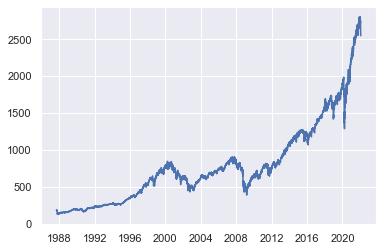

In [3]:
price = russell[['Adj Close']]
plt.plot(price)

,ret
Date,
1988-09-30,-0.243367
1988-10-31,0.026833
1988-11-30,0.096877
1988-12-31,0.036213
1989-01-31,0.061823
...,...
2021-09-30,0.198881
2021-10-31,0.317748
2021-11-30,0.144870


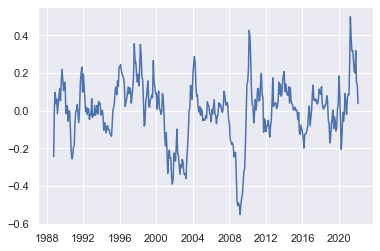

In [4]:
price.index = pd.to_datetime(price.index)
price = price.resample('M').last()
ret_12 = (price / price.shift(12) - 1).dropna()
ret_12.columns = ['ret']
ret_12 = ret_12 - ret_12.mean()

plt.plot(ret_12)
ret_12

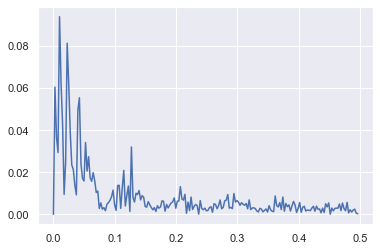

In [5]:
# 数据长度
N = len(ret_12)
# 采样频率
fs = 1

x = np.array(ret_12.index)
y = np.array(ret_12['ret'])
y_f = fft(y)
# x_f = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)
x_f = fftfreq(N, 1 / fs)[:N // 2]

plt.plot(x_f, 2.0 / N * np.abs(y_f[: N // 2]))
plt.show()
df = pd.DataFrame(2.0 / N * np.abs(y_f[: N // 2]), columns=['A'], index=x_f)
df
df['T'] = 1 / df.index

In [6]:
df_sorted = df.sort_values("A", ascending=False)
df_sorted.head(10)

,A,T
0.009975,0.093902,100.250000
0.022444,0.081311,44.555556
0.024938,0.062255,40.100000
0.012469,0.062132,80.200000
0.002494,0.060482,401.000000
0.042394,0.055412,23.588235
0.039900,0.049571,25.062500
0.014963,0.042969,66.833333
0.027431,0.039092,36.454545
0.004988,0.036879,200.500000


In [7]:
df.set_index("T", inplace=True)

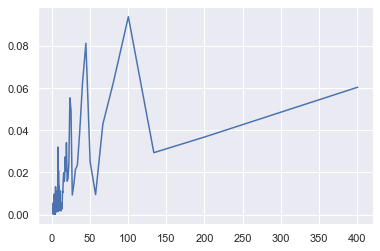

In [8]:
plt.plot(df)

In [14]:
df = df.iloc[:0:-1]

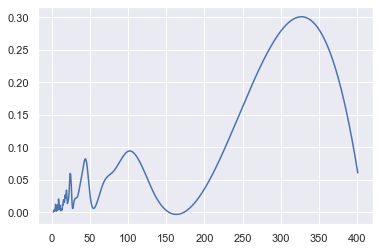

In [16]:
from scipy.interpolate import make_interp_spline

x = np.array(df.index)
y = np.array(df['A'])
x_smooth = np.linspace(x.min(), x.max(), 1000) #300 represents number of points to make between T.min and T.max
y_smooth = make_interp_spline(x, y)(x_smooth)
plt.plot(x_smooth, y_smooth)